In [493]:
# Package Imports

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import numpy as np
from collections import OrderedDict
import time
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms, models
from PIL import Image

In [494]:
# Data loading
currentPath = os.getcwd();
dataDir = currentPath + '/dog'
trainDir = dataDir + '/training'
validDir = dataDir + '/validation'
testDir = dataDir + '/testing'

dataTransforms = {
    'training' : transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.RandomRotation(30),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], 
                                                         [0.229, 0.224, 0.225])]),
                                                            
    'validation' : transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])]),

    'testing' : transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])
}


# Load the datasets with ImageFolder
imageDatasets = {
    'training' : datasets.ImageFolder(trainDir, transform=dataTransforms['training']),
    'validation' : datasets.ImageFolder(validDir, transform=dataTransforms['validation']),
    'testing' : datasets.ImageFolder(testDir, transform=dataTransforms['testing'])
}

# Using the image datasets and the trainforms, define the dataloaders
dataLoaders = {
    'training' : torch.utils.data.DataLoader(imageDatasets['training'], batch_size=64, shuffle=True),
    'validation' : torch.utils.data.DataLoader(imageDatasets['validation'], batch_size=64, shuffle=True),
    'testing' : torch.utils.data.DataLoader(imageDatasets['testing'], batch_size=64, shuffle=False)
}

class_to_idx = imageDatasets['training'].class_to_idx
print(class_to_idx)

{'1': 0}


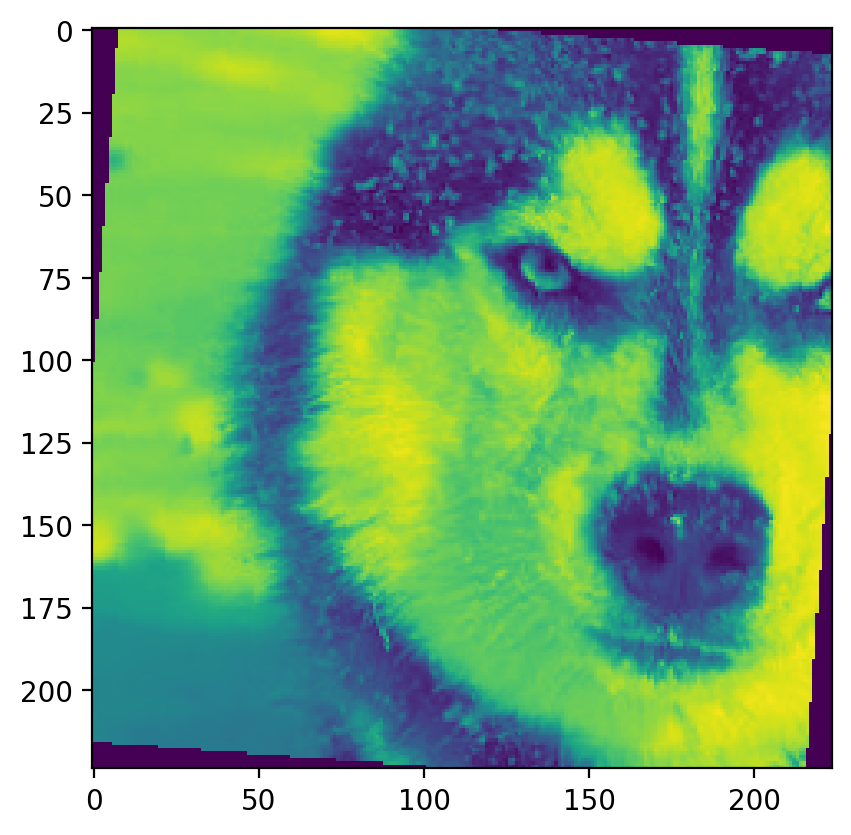

In [495]:
# Show random image
images, labels = next(iter(dataLoaders["training"]))
plt.imshow(images[0,0])

In [496]:
# Collect the dog names
dogNames = {}
imageList = os.listdir(trainDir + '/1')
for index in range(0, len(imageList)):
    fileName = imageList[index]
    filePop = fileName.split('.')
    dogNames[index] = filePop[0]
print(dogNames)

{0: 'poodle', 1: 'golden', 2: 'alaska', 3: 'corgi'}


In [497]:
# Build and train network

def get_model():
    model = models.densenet121(weights='DEFAULT')
    return model

def build_model(hidden_layers, class_to_idx):
    model = get_model()
    for param in model.parameters():
        param.requires_grad = False
    
    classifier_input_size = model.classifier.in_features
    print("Input size: ", classifier_input_size)
    output_size = 102

    from collections import OrderedDict
    classifier = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(classifier_input_size, hidden_layers)),
        ('relu', nn.ReLU()),
        ('fc2', nn.Linear(hidden_layers, output_size)),
        ('output', nn.LogSoftmax(dim=1))
    ]))
    
    model.classifier = classifier
    model.class_to_idx = class_to_idx
    return model

In [498]:
hidden_layers = 512

model = build_model(hidden_layers, class_to_idx)

Input size:  1024


In [499]:

def train(model, epochs, learning_rate, criterion, optimizer, training_loader, validation_loader):
    
    model.train()
    print_every = 1
    steps = 0
    use_gpu = False
    
    if torch.cuda.is_available():
        use_gpu = True
        model.cuda()
    else:
        model.cpu()

    for epoch in range(epochs):
        running_loss = 0
        for inputs, labels in iter(training_loader):
            steps += 1

            if use_gpu:
                inputs = Variable(inputs.double().cuda())
                labels = Variable(labels.long().cuda()) 
            else:
                inputs = Variable(inputs)
                labels = Variable(labels) 

            optimizer.zero_grad()
            output = model.forward(inputs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.data.item()

            if steps % print_every == 0:
                validation_loss, accuracy = validate(model, criterion, validation_loader)

                print("Epoch: {}/{} ".format(epoch+1, epochs),
                        "Training Loss: {:.3f} ".format(running_loss/print_every),
                        "Validation Loss: {:.3f} ".format(validation_loss),
                        "Validation Accuracy: {:.3f}".format(accuracy))

In [500]:
def validate(model, criterion, data_loader):
    model.eval()
    accuracy = 0
    test_loss = 0
    
    for inputs, labels in iter(data_loader):
        if torch.cuda.is_available():
            inputs = Variable(inputs.double().cuda())
            labels = Variable(labels.long().cuda()) 
        else:
            inputs = Variable(inputs)
            labels = Variable(labels)

        output = model.forward(inputs)
        test_loss += criterion(output, labels).data.item()
        ps = torch.exp(output).data 
        equality = (labels.data == ps.max(1)[1])
        accuracy += equality.type_as(torch.DoubleTensor()).mean()
        model.train()

    return test_loss/len(data_loader), accuracy/len(data_loader)

In [501]:
epochs = 5
learning_rate = 0.001
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)
train(model, epochs, learning_rate, criterion, optimizer, dataLoaders['training'], dataLoaders['validation'])

Epoch: 1/5  Training Loss: 4.518  Validation Loss: 2.547  Validation Accuracy: 1.000
Epoch: 2/5  Training Loss: 2.122  Validation Loss: 0.880  Validation Accuracy: 1.000
Epoch: 3/5  Training Loss: 0.540  Validation Loss: 0.121  Validation Accuracy: 1.000
Epoch: 4/5  Training Loss: 0.046  Validation Loss: 0.012  Validation Accuracy: 1.000
Epoch: 5/5  Training Loss: 0.004  Validation Loss: 0.001  Validation Accuracy: 1.000


In [502]:
# Validate data
test_loss, accuracy = validate(model, criterion, dataLoaders['testing'])
print("Val. Accuracy: {:.3f}".format(accuracy))
print("Val. Loss: {:.3f}".format(test_loss))

Val. Accuracy: 1.000
Val. Loss: 0.006


In [503]:
# Save the checkpoint 

checkpoint_path = 'checkpoint.pth'

state = {
    'arch': 'densenet121',
    'learning_rate': learning_rate,
    'hidden_layers': hidden_layers,
    'epochs': epochs,
    'state_dict': model.state_dict(),
    'optimizer' : optimizer.state_dict(),
    'class_to_idx' : model.class_to_idx
}

torch.save(state, checkpoint_path)

In [504]:
# Load the checkpoint and rebuilds the model
state = torch.load(checkpoint_path)
learning_rate = state['learning_rate']
class_to_idx = state['class_to_idx']

model = build_model(hidden_layers, class_to_idx)

model.load_state_dict(state['state_dict'])
optimizer.load_state_dict(state['optimizer'])

print("Loaded '{}' (arch={}, hidden_layers={}, epochs={})".format(
    checkpoint_path, 
    state['arch'], 
    state['hidden_layers'], 
    state['epochs']))

Input size:  1024
Loaded 'checkpoint.pth' (arch=densenet121, hidden_layers=512, epochs=5)


In [505]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    size = 224
    # TODO: Process a PIL image for use in a PyTorch model
    width, height = image.size
    
    if height > width:
        height = int(max(height * size / width, 1))
        width = int(size)
    else:
        width = int(max(width * size / height, 1))
        height = int(size)
        
    resized_image = image.resize((width, height))
        
    x0 = (width - size) / 2
    y0 = (height - size) / 2
    x1 = x0 + size
    y1 = y0 + size
    cropped_image = image.crop((x0, y0, x1, y1))
    np_image = np.array(cropped_image) / 255.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])     
    np_image_array = (np_image - mean) / std
    np_image_array = np_image.transpose((2, 0, 1))
    
    return np_image_array

In [506]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [507]:
def predict(image_path, model, topk=5):
    model.eval()
    use_gpu = False 
    if torch.cuda.is_available():
        use_gpu = True
        model = model.cuda()
    else:
        model = model.cpu()
    image = Image.open(image_path)
    np_array = process_image(image)
    tensor = torch.from_numpy(np_array)
    if use_gpu:
        var_inputs = Variable(tensor.float().cuda())
    else:       
        var_inputs = Variable(tensor.float())
    var_inputs = var_inputs.unsqueeze(0)
    output = model.forward(var_inputs)  
    ps = torch.exp(output).data.topk(topk)
    probabilities = ps[0].cpu() if use_gpu else ps[0]
    classes = ps[1].cpu() if use_gpu else ps[1]
    class_to_idx_inverted = {model.class_to_idx[k]: k for k in model.class_to_idx}
    mapped_classes = list()
    for label in classes.numpy()[0]:
        if (label in class_to_idx_inverted):
            mapped_classes.append(class_to_idx_inverted[label])
    return probabilities.numpy()[0], mapped_classes

image_path = testDir + '/1/1.jpeg'
result = predict(image_path, model)

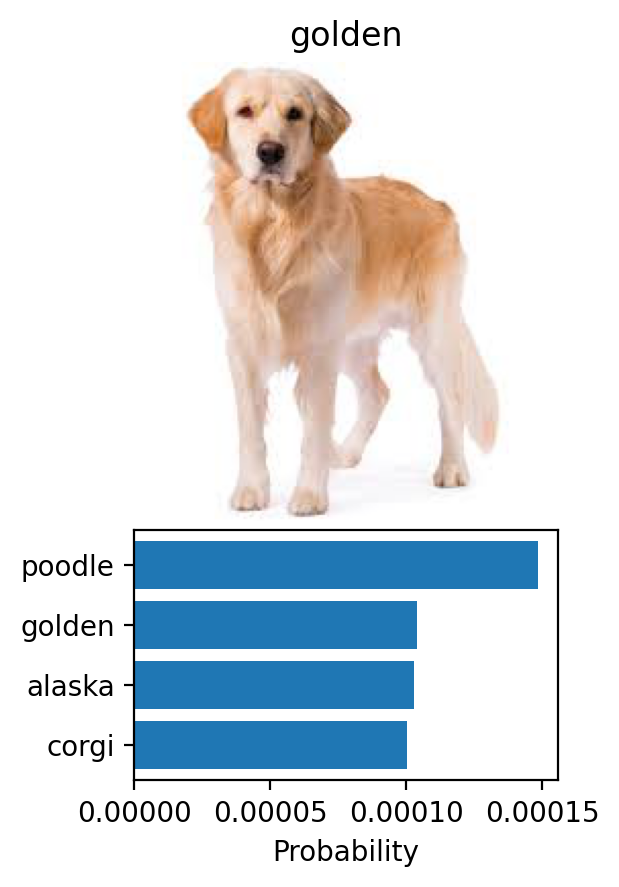

In [508]:
# Display an image along with the top 4 classes

image_path = testDir + '/1/1.jpeg'
probabilities, classes = predict(image_path, model)
max_index = np.argmax(probabilities)
max_probability = probabilities[max_index]
label = classes[max_index]
fig = plt.figure(figsize=(5,5))
ax1 = plt.subplot2grid((15,9), (0,0), colspan=9, rowspan=9)
ax2 = plt.subplot2grid((15,9), (9,2), colspan=5, rowspan=5)

image = Image.open(image_path)
ax1.axis('off')
ax1.set_title(dogNames[int(label)])
ax1.imshow(image)
labels = []
for cl in dogNames:
    labels.append(dogNames[cl])
y_pos = np.arange(4)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(labels)
ax2.invert_yaxis()  # probabilities read top-to-bottom
ax2.set_xlabel('Probability')
ax2.barh(y_pos, probabilities[1:5], xerr=0, align='center')

plt.show()